# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [75]:
train = pd.read_csv("./data\\movies_train.csv")
test = pd.read_csv("./data\\movies_test.csv")
sub = pd.read_csv("./data\\submission.csv")

In [76]:
# train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

# train.shape, test.shape

In [77]:
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [78]:
# train과 test의 데이터를 출력해봅니다

- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [80]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
train.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [82]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [83]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [84]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

<AxesSubplot:>

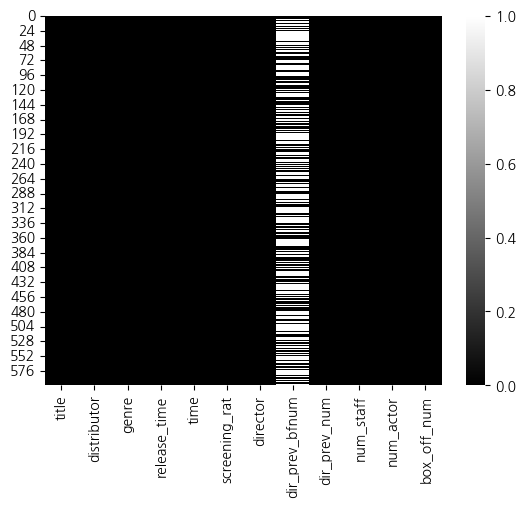

In [85]:
# 결측치를 시각화해봅니다
sns.heatmap(train.isnull(), cmap="gray")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [86]:
# \(|주|\) 는 데이터에서 제거해줍니다

In [87]:
train["distributor"] = train["distributor"].str.replace("\(|주|\)","")

In [88]:
train["distributor"]

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598    CJ 엔터테인먼트
599    CJ 엔터테인먼트
Name: distributor, Length: 600, dtype: object

<AxesSubplot:xlabel='distributor', ylabel='count'>

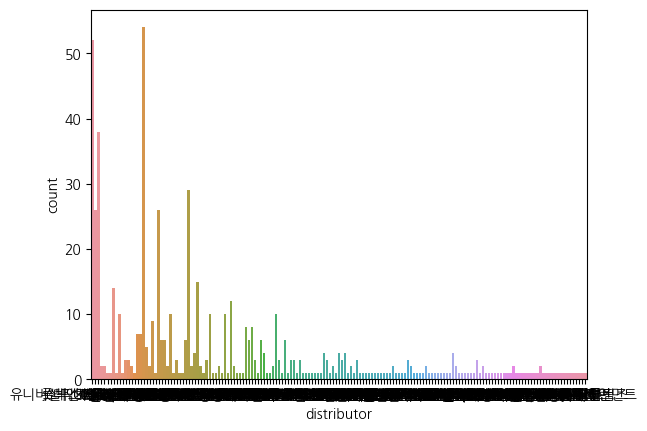

In [89]:
sns.countplot(data=train, x="distributor")

<AxesSubplot:xlabel='distributor', ylabel='count'>

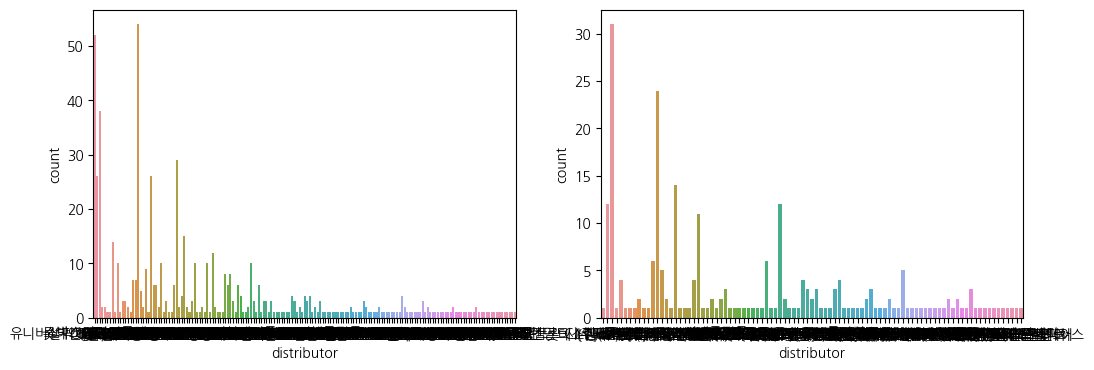

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=train, x="distributor", ax=ax[0])
sns.countplot(data=test, x="distributor", ax=ax[1])

In [91]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

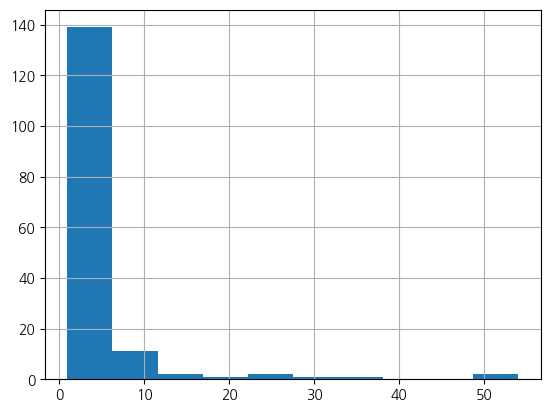

In [92]:
_ = train["distributor"].value_counts().hist()

In [93]:
# def age_pclass(cols):
#     Age = cols[0]
#     Pclass = cols[1]
    
#     if pd.isnull(Age):
#         if Pclass==1: return 38
#         elif Pclass==2: return 29
#         else: return 25
#     else: return Age

In [16]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(~):
    if train["distributor"].value_counts() <= 15:
        train["distributor"] = "소형"
    else:
        train["distributor"] = "대형"


In [94]:
train_vc = train["distributor"].value_counts()
train_vc15 = train_vc[train_vc <= 15]
train15 = train_vc15.index.to_list()
train15

['골든타이드픽처스',
 '케이알씨지',
 '영화사조제',
 '영화사진진',
 '시너지',
 '키노아이',
 '어뮤즈',
 '인디플러그',
 '인벤트디',
 'KTG상상마당',
 '리틀빅픽처스',
 '스폰지',
 'CGV아트하우스',
 '팝엔터테인먼트',
 '무비꼴라쥬',
 '시네마서비스',
 'BoXoo엔터테인먼트',
 '필라멘트픽쳐스',
 '마인스엔터테인먼트',
 '메가박스플러스엠',
 '드림팩트엔터테인먼트',
 '씨너스엔터테인먼트',
 '홀리가든',
 '나이너스엔터테인먼트',
 '엣나인필름',
 '마노엔터테인먼트',
 '마운틴픽처스',
 '이십세기폭스코리아',
 '트리필름',
 '이모션픽처스',
 '타임스토리그룹',
 'CJEM영화부문',
 '김기덕필름',
 '씨네그루키다리이엔티',
 '영화제작전원사',
 '싸이더스',
 'KT',
 '브릿지웍스',
 'SBS콘텐츠허브',
 '에이원엔터테인먼트',
 '화앤담이엔티',
 '싸이더스FNH',
 '와이드릴리즈',
 '리틀빅픽쳐스',
 '액티버스엔터테인먼트',
 '에스피엠',
 '프레인글로벌',
 '드림로드',
 '웃기씨네',
 '조이앤시네마',
 '쇼박스미디어플렉스',
 '백두대간',
 'CJEMPictures',
 '노바엔터테인먼트',
 '서울독립영화제',
 '파이오니아21',
 '스톰픽쳐스코리아',
 '판씨네마',
 '패뷸러스',
 '영화사조아',
 '두엔터테인먼트',
 '영화사',
 '전국제영화제',
 '프리비젼엔터테인먼트',
 '스마일이엔티',
 '미디어데이',
 '크리에이티브컴즈',
 'ysfilm',
 '이달투',
 '고구마공작소',
 'M2픽처스',
 '필름라인',
 '스튜디오느림보',
 '새인컴퍼니',
 '인피니티엔터테인먼트',
 '상구네필름',
 '에이블엔터테인먼트',
 '케이엠스타',
 '미라클필름',
 '프로젝트엠피',
 '머니필름',
 '롤러코스터프로덕션',
 'SK플래닛',
 '유비콘텐츠',
 '인터콘미디어',
 '스튜디오블루',
 '랠리버튼',
 '씨엠닉스',
 '팜코리아미디어',
 '

In [62]:
print(type(train15))

<class 'list'>


In [95]:
train["distributor_new"] = train["distributor"].apply(lambda x : "소형" if x in train15 else "대형")

In [65]:
train[["distributor_new", "distributor"]]

,distributor_new,distributor
0,대형,롯데엔터테인먼트
1,대형,쇼박스
2,대형,쇼박스
3,대형,NEW
4,소형,쇼박스미디어플렉스
...,...,...
595,대형,NEW
596,대형,쇼박스
597,대형,마운틴픽쳐스
598,대형,CJ엔터테인먼트


In [96]:
# train["distributor"].apply(distributor_band).value_counts()

In [66]:
# 위 함수를 train과 test에 모두 적용합니다
test["distributor"] = test["distributor"].apply(lambda x : "소형" if x in train15 else "대형")

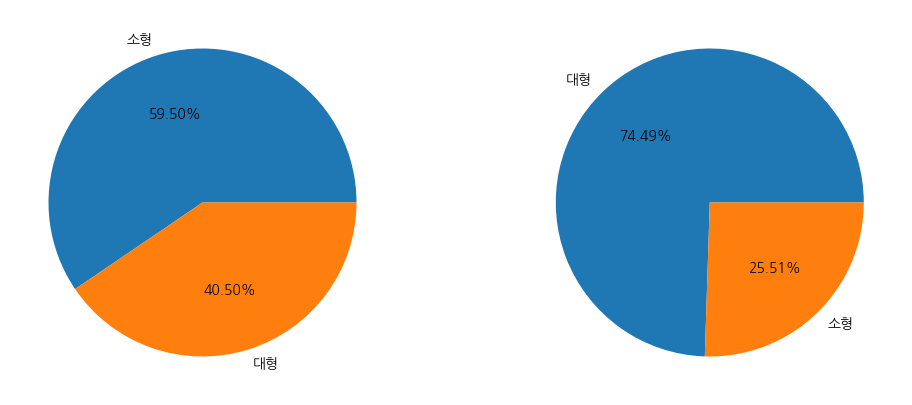

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor_new"].value_counts().values, labels=train["distributor_new"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

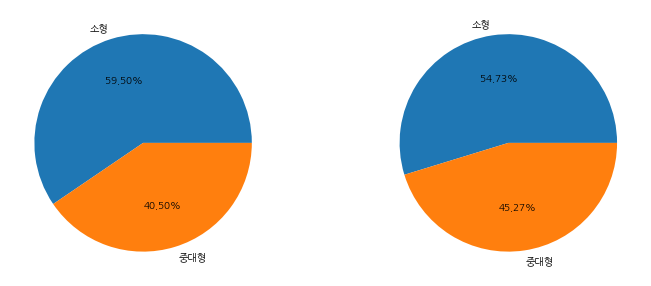

In [19]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor_new"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [104]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [21]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다

In [105]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

NameError: name 'rank' is not defined

In [23]:
# 인코딩 전의 장르 컬럼은 버려줍니다

### release_time: 개봉일

In [107]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train["release_time"] = pd.to_datetime(train["release_time"])

In [108]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] = train["release_time"].dt.year
train["month"] = train["release_time"].dt.month
train["day"] = train["release_time"].dt.day
train["dayofweek"] = train["release_time"].dt.dayofweek

In [26]:
# 기존 데이터는 삭제합니다

Text(0.5, 1.0, 'dayofweek')

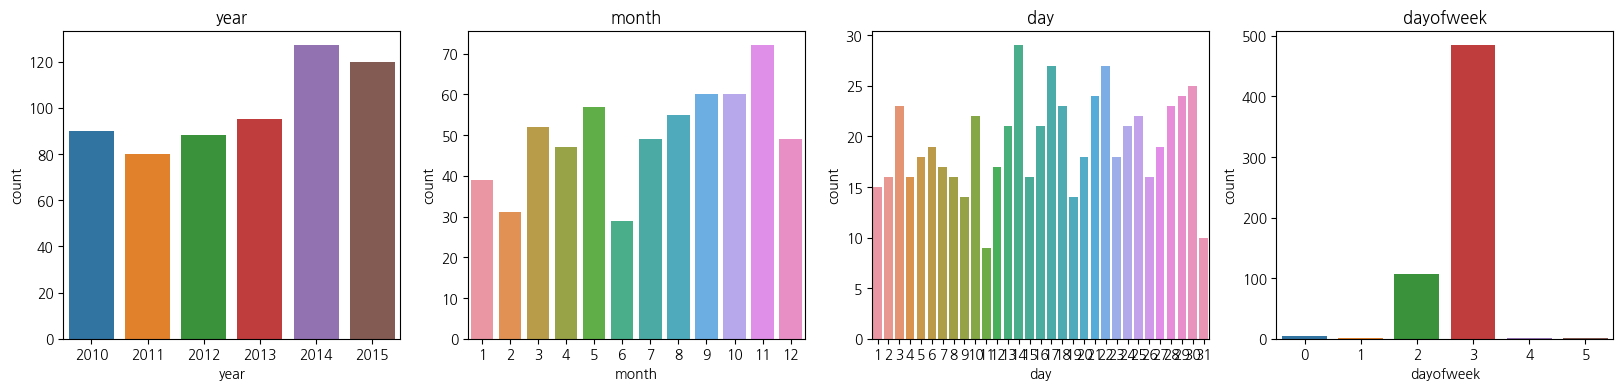

In [113]:
# 요일별로 시각화 해봅니다
fig, ax = plt.subplots(1, 4,figsize=(20,4))
sns.countplot(data= train, x="year", ax=ax[0]).set_title("year")
sns.countplot(data= train, x="month", ax=ax[1]).set_title("month")
sns.countplot(data= train, x="day", ax=ax[2]).set_title("day")
sns.countplot(data= train, x="dayofweek", ax=ax[3]).set_title("dayofweek")

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [114]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num', 'distributor_new', 'year',
       'month', 'day', 'dayofweek'],
      dtype='object')

In [28]:
# 제목과 감독 데이터는 버려줍니다


In [29]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [115]:
train.describe(include="object")

,title,distributor,genre,screening_rat,director,distributor_new
count,600,600,600,600,600,600
unique,600,159,12,4,472,2
top,개들의 전쟁,CJ엔터테인먼트,드라마,청소년 관람불가,홍상수,소형
freq,1,54,221,204,7,357


In [117]:
train["screening_rat"].unique()

array(['청소년 관람불가', '15세 관람가', '전체 관람가', '12세 관람가'], dtype=object)

In [120]:
# 범주형 데이터들을 인코딩해줍니다
# screening_rat -> one hot
# distributor_new -> one hot



In [31]:
# 피처와 라벨을 구합니다


['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

### Log Scale

In [32]:
# 등장 배우의 수에 로그 스케일을 적용합니다

In [33]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [34]:
test.shape

(243, 16)

### Random Forest

rmse: 1377636.6138653848


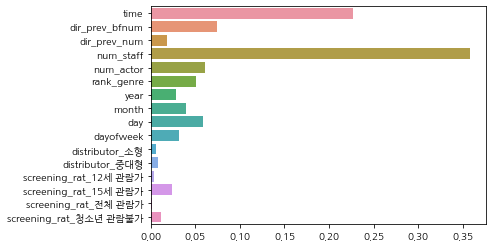

### XGBoost

rmse: 1444161.2032999645


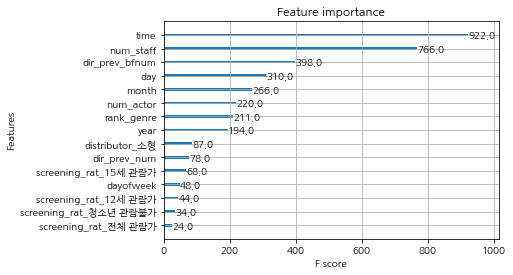

### LightGBM

rmse: 1444161.2032999645


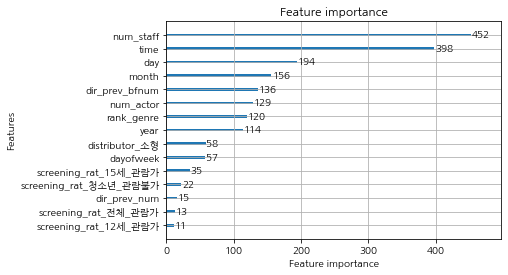